## KDEs for time series

To illustrate the `kdetools` API, fit a KDE time series model to some example data from `statsmodels` and simulate from it.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [3]:
# Extended KDE functions including conditional sampling
import kdetools as kt

#### Univariate example

Load sunspot data:

In [4]:
sspot = sm.datasets.sunspots.load_pandas().data.astype(int).set_index('YEAR')
print(sspot.shape)
sspot.head(3)

(309, 1)


,SUNACTIVITY
YEAR,
1700,5
1701,11
1702,16


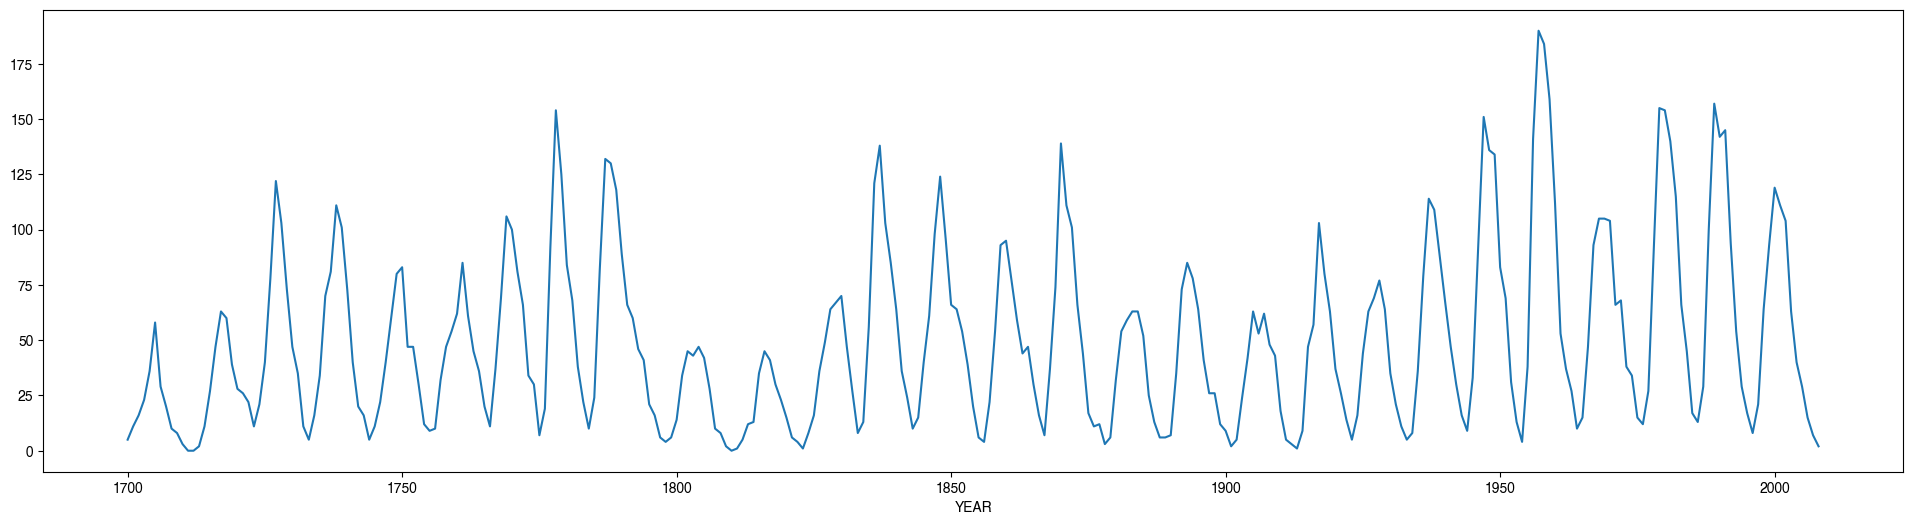

In [5]:
sspot['SUNACTIVITY'].plot(figsize=(24,6));

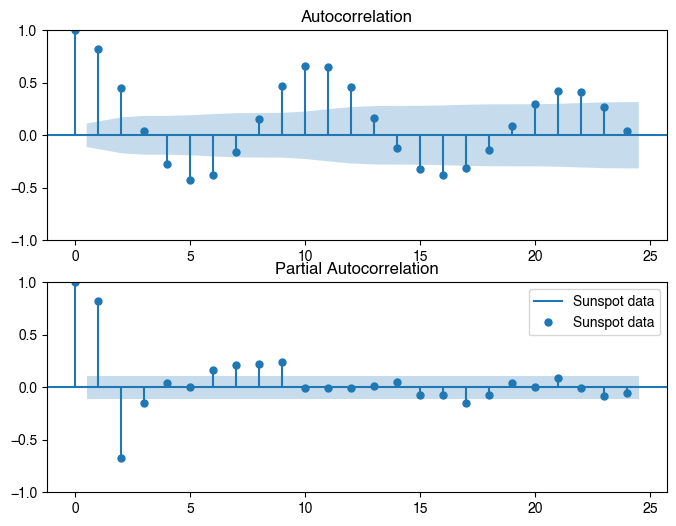

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6))
plot_acf(sspot, lags=24, ax=ax1, label='Sunspot data')
plot_pacf(sspot, lags=24, ax=ax2, label='Sunspot data')
ax2.legend();

Model the joint distribution of lag-0 to lag-7 values:

In [7]:
p = 7
X = pd.concat([sspot[['SUNACTIVITY']].shift(i).add_suffix(f'-{i}') for i in range(p, -1, -1)], axis=1).dropna()[:175]
print(X.shape)
X.head()

(175, 8)


,SUNACTIVITY-7,SUNACTIVITY-6,SUNACTIVITY-5,SUNACTIVITY-4,SUNACTIVITY-3,SUNACTIVITY-2,SUNACTIVITY-1,SUNACTIVITY-0
YEAR,,,,,,,,
1707,5.0,11.0,16.0,23.0,36.0,58.0,29.0,20
1708,11.0,16.0,23.0,36.0,58.0,29.0,20.0,10
1709,16.0,23.0,36.0,58.0,29.0,20.0,10.0,8
1710,23.0,36.0,58.0,29.0,20.0,10.0,8.0,3
1711,36.0,58.0,29.0,20.0,10.0,8.0,3.0,0


Note also that since this is a count model, need to do a transformation to prevent modelling negative numbers.

In [8]:
X = np.sqrt(X)

Visualise dependence structure:

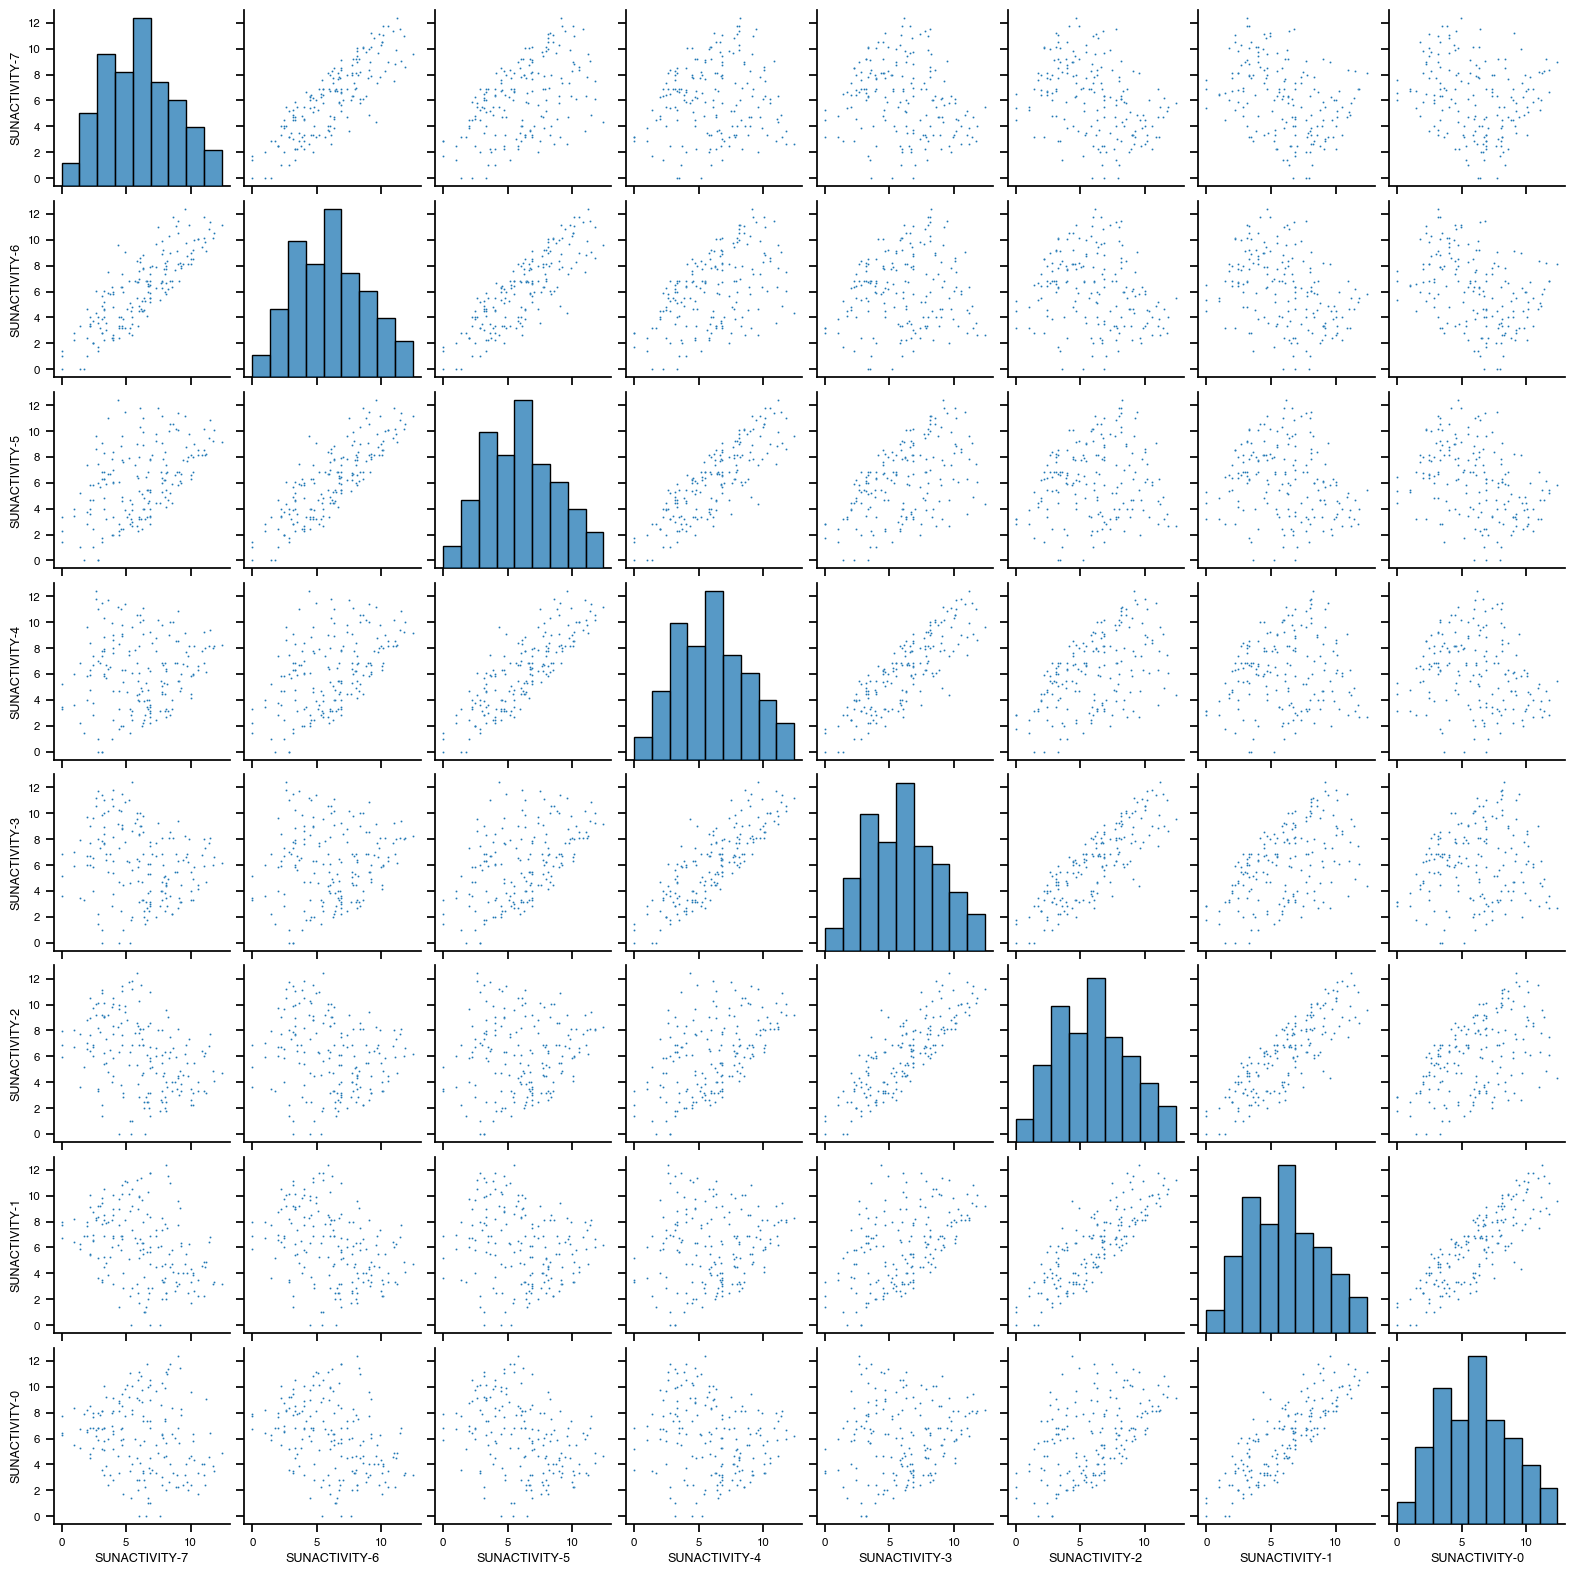

In [9]:
sns.set_context('notebook', font_scale=0.75)
sns.pairplot(X, height=2, plot_kws={'s': 2});

#### Fit KDE model to data and simulate

Fit a multidimensional KDE, noting that the base `gaussian_kde` class expects data with features as rows and instances as columns, hence the transpose:

In [10]:
kde = kt.gaussian_kde(X.T)
kde.factor

0.6502497031564451

Set the bandwidth using new cross-validation method:

In [11]:
kde.set_bandwidth(bw_method='cv', bw_type='covariance')
kde.factor

array([0.67719321])

Define an array to store the results and populate with the initial values from the training data

In [12]:
# Data index at which to start simulating
ix0 = 174

# Ensemble members M and time steps N to simulate
M, N = 1000, sspot.shape[0] - ix0
#M, N = 1000, 20

# Create array to store simulations and populate first p time steps
sims = np.zeros((M, N))
sims[:,:p] = X.values[ix0,:p]

Run time-stepping loop:

In [13]:
np.random.seed(0)

for i in tqdm(range(p, N)):
    x_cond = np.vstack([sims[:,i-j] for j in range(p, 0, -1)]).T
    sims[:,i] = kde.conditional_resample(1, x_cond=x_cond, dims_cond=range(p))[:,0,0]

# Reverse the transformation
sims = sims**2

# Calculate mean of all simulations, and 33rd and 66th percentiles
sims_q05 = pd.DataFrame(np.quantile(sims, 0.33, axis=0), columns=sspot.columns).add_suffix('_33rd')
sims_mean = pd.DataFrame(sims.mean(axis=0), columns=sspot.columns).add_suffix('_mean')
sims_q95 = pd.DataFrame(np.quantile(sims, 0.66, axis=0), columns=sspot.columns).add_suffix('_66th')

  0%|          | 0/128 [00:00<?, ?it/s]

##### Compare summary statistics

In [14]:
pd.DataFrame([sspot['SUNACTIVITY'].describe().rename('orig'), 
              pd.Series(sims.ravel(), name='sim').describe()])

,count,mean,std,min,25%,50%,75%,max
orig,309.0,49.368932,40.405571,0.000000e+00,16.000000,40.00000,69.000000,190.00000
sim,135000.0,48.806158,43.387112,3.630140e-09,13.865843,38.01897,72.081775,342.33427


##### Visualise the simulated results

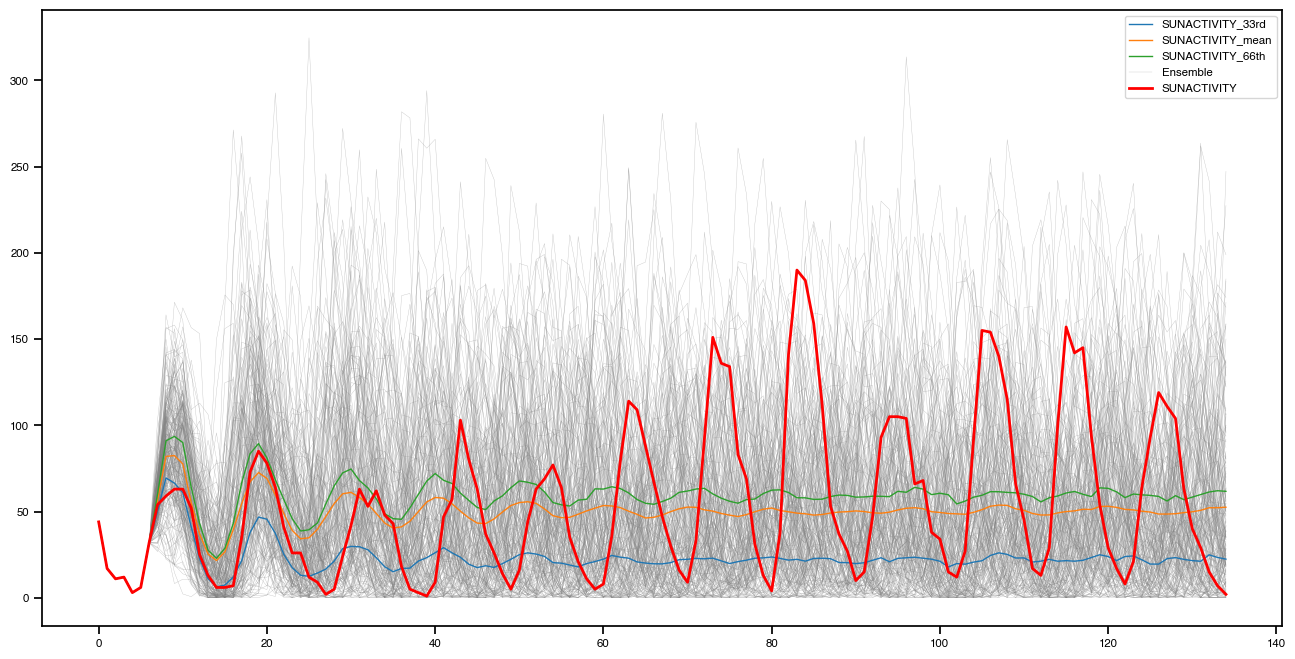

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))

sims_q05.plot(ax=ax, ls='-', lw=1, label='5th percentile')
sims_mean.plot(ax=ax, ls='-', lw=1, label='mean')
sims_q95.plot(ax=ax, ls='-', lw=1, label='95th percentile')

for i in range(min(M, 200)):
    ax.plot(sims[i], color='0.5', lw=0.25, zorder=-3, alpha=0.5, label='Ensemble' if i==0 else None)

sspot.iloc[ix0:ix0+N].reset_index(drop=True).plot(ax=ax, lw=2, color='r', label='Actual data')
ax.legend();

##### Compare full and partial autocorrelations of input data

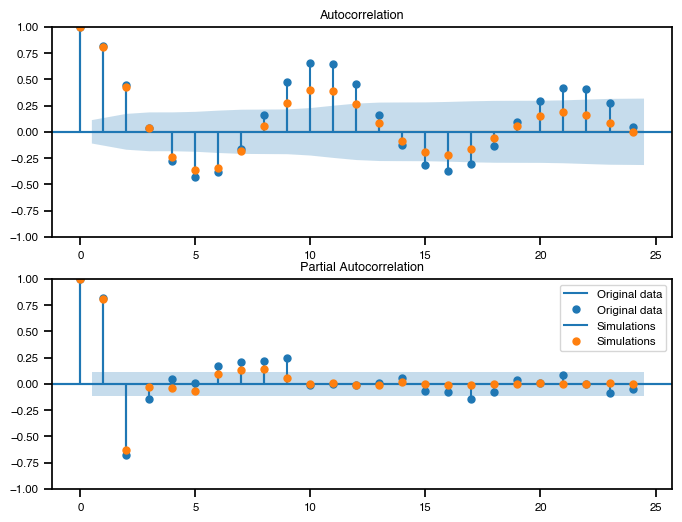

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6))
plot_acf(sspot, lags=24, ax=ax1, label='Original data')
plot_acf(sims.ravel(), lags=24, ax=ax1, label='Simulations')
plot_pacf(sspot, lags=24, ax=ax2, label='Original data')
plot_pacf(sims.ravel(), lags=24, ax=ax2, label='Simulations')
ax2.legend();

##### Compare ECDFs

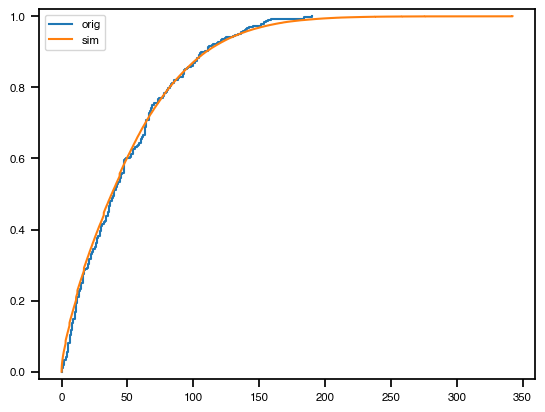

In [17]:
fig, ax = plt.subplots()
ax.ecdf(sspot['SUNACTIVITY'], label='orig')
ax.ecdf(sims.ravel(), label='sim')
ax.set_ylim((-0.02, 1.02)); ax.legend();